In [1]:
import os
if os.getcwd() != 'pwd':
   %cd ../../..

/home/guorui/ICSDICE


/home/guorui/miniconda3/envs/ICSDICE/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import jax
import numpy as np
import gymnasium as gym
import orbax.checkpoint

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from icrl.maze.utility import (
    ValueCritic,
    concatenated_indices,
    BatchData,
)
from icrl.maze.exp.OptiDice import OptiDice
from icrl.maze.exp.ICSDICE import ICSDICENoIS,ICSDICEBaseline

TrainClass = {"OptiDice": OptiDice, "Our Method(w/o discount)":  ICSDICEBaseline, "Our Method": ICSDICENoIS}
env_id = "Maze2d_simple"
env = gym.make(env_id)

key = jax.random.PRNGKey(0)
key, actor_key, qf_key, ent_vkey = jax.random.split(key, 4)

obs = jnp.array([env.observation_space.sample()])
action = jnp.array([env.action_space.sample()])


def get_data(index_list):
    checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    data = checkpointer.restore(
        "dataset/maze"
    )
    dataset = {}
    start_index = 0
    end_index = 50000
    dataset["observations"] = jnp.array(
        data[0][start_index:end_index, 0, :4].astype(jnp.float32)
    )
    startpoint = (-1, -1)
    dataset["index"] = jnp.array(
        (dataset["observations"][:, 0] == startpoint[0])
        & (dataset["observations"][:, 1] == startpoint[1])
    )
    intervals = concatenated_indices(dataset["index"])[1]
    sample_interval = [intervals[i] for i in index_list]
    print(index_list)
    selected_index = np.concatenate(
        [np.arange(start, end) for (start, end) in sample_interval]
    )
    dataset["observations"] = jnp.array(
        data[0][selected_index, 0, :4].astype(jnp.float32)
    )
    dataset["next_observations"] = jnp.array(
        data[1][selected_index, 0, :4].astype(jnp.float32)
    )
    dataset["actions"] = jnp.array(data[2][selected_index, 0])
    dataset["rewards"] = (jnp.array(data[4][selected_index, 0].clip(0)) - 100) / 100*5
    dataset["infos"] = data[5]
    dataset["terminals"] = jnp.array(data[3][selected_index, 0])
    dataset["timeouts"] = jnp.zeros_like(dataset["terminals"])
    startpoint = (-1, -1)
    dataset["index"] = jnp.array(
        (dataset["observations"][:, 0] == startpoint[0])
        & (dataset["observations"][:, 1] == startpoint[1])
    )
    dataset["index"] = jnp.array(concatenated_indices(dataset["index"])[0])
    dataset["init_eff"] = 1 / (dataset["index"] == 0).mean()
    dataset["init_obs"] = dataset["observations"][dataset["index"] == 0]
    return dataset


# dataset = get_data([193, 5, 8, 63])
dataset = get_data([5,8, 63,67])


def sample_batch(key):
    sample_key, key = jax.random.split(key, 2)
    expert_indice = jax.random.randint(
        sample_key, minval=0, maxval=len(dataset["observations"]), shape=(256,)
    )
    init_key, key = jax.random.split(key, 2)
    init_indice = jax.random.randint(
        init_key, minval=0, maxval=len(dataset["init_obs"]), shape=(256,)
    )
    Policy_Batch = BatchData(
        dataset["observations"][expert_indice],
        dataset["actions"][expert_indice],
        dataset["next_observations"][expert_indice],
        dataset["rewards"][expert_indice],
        dataset["terminals"][expert_indice],
        dataset["index"][expert_indice],
        cost_region(
            dataset["next_observations"][expert_indice, 0],
            dataset["next_observations"][expert_indice, 1],
        ),
        dataset["init_obs"][init_indice],
    )

    return Policy_Batch, key


# def cost_region(x, y):
#     return (x < -0.6) & (y < 0.3) & (y > -0.3)


def cost_region(x, y):
    return jnp.zeros_like(x)

[5, 8, 63, 67]


In [3]:
def get_train_obj(trainclass, gamma, alpha):
    obj = trainclass(gamma=gamma, alpha=alpha)
    if trainclass.__name__  in ["ICSDICENoDiscount","ICSDICE"] :
        obj.init_eff = dataset["init_eff"]
    return obj


def train_baseline(trainclass, gamma=0.99, alpha=0.05):
    train_obj = get_train_obj(trainclass, gamma, alpha)
    agent_state = train_obj.GetTrainState(obs)
    _reward_train_step = jax.jit(train_obj.reward_train_step)

    def reward_train_step_body(carry, step):
        agentstate = carry
        Batch, key = sample_batch(agentstate.key)
        agentstate = agentstate._replace(key=key)
        agentstate, callback_log = _reward_train_step(agentstate, Batch)
        return agentstate, callback_log
    total_step=1000
    agent_states=[]
    for i in range(total_step):
        if i % (total_step//10)==0:
            agent_states.append(agent_state)
        agent_state, reward_callback_log = jax.lax.scan(
            reward_train_step_body,
            (agent_state),
            (),
            length=100,
        )
    return agent_state, reward_callback_log,agent_states


vf = ValueCritic()


def plot_value(trainclass, agent_state, alpha, gamma):
    train_obj = get_train_obj(trainclass, gamma, alpha)
    tdv, v = train_obj.get_tdv(
        agent_state,
        dataset["observations"],
        dataset["next_observations"],
        dataset["rewards"],
    )
    return tdv

In [4]:
alphas = [0.01,0.1,1]
tdvs = {}
plots = {}
agent_states = {}
for trainclass in TrainClass.values():
    for i, alpha in enumerate(alphas):
        gamma = 0.99
        method=trainclass.__name__
        agent_state_without_q, reward_callback_log_without_q,agent_states[(method, alpha)] = train_baseline(
            trainclass, gamma=gamma, alpha=alpha
        )
        tdvs[(method, alpha)] = plot_value(
            trainclass, agent_state_without_q, alpha, gamma
        )


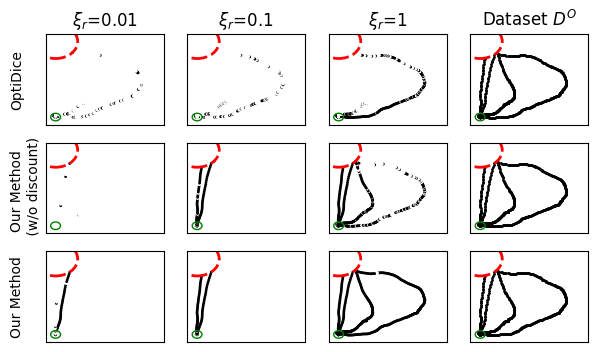

In [5]:
from matplotlib.backends.backend_pdf import PdfPages
limits = np.linspace(-2, -1, 3)
plot_alphas = sorted(alphas)
fig = plt.figure( figsize=(7, 4))
axes=[]
for i, trainclass in enumerate(TrainClass.values()):
    method=trainclass.__name__
    axes.append([])
    for j, alpha in enumerate(plot_alphas):
        ax=fig.add_subplot(len(TrainClass.keys()), len(plot_alphas)+1,i*(len(plot_alphas)+1)+j+1)
        axes[i].append(ax)
        ax.scatter(
            dataset["observations"][:, 0],
            dataset["observations"][:, 1],
            c=(tdvs[(method, alpha)] > -1)
            * (
                1
                - cost_region(
                    dataset["next_observations"][:, 0],
                    dataset["next_observations"][:, 1],
                )
            ),
            vmin=0,
            vmax=1,
            cmap="Greys",
            s=1,
            rasterized=True,
        )
        masked=cost_region(
                    dataset["next_observations"][:, 0],
                    dataset["next_observations"][:, 1],
                )>0
        ax.scatter(
            dataset["observations"][masked, 0],
            dataset["observations"][masked, 1],
            marker="x",
            c="red"
        )
        cir = plt.Circle((-1, -1), 0.1, color='green',fill=False)
        ax.add_patch(cir)
        cir = plt.Circle((-1, 1), 0.45, color='r',fill=False,linewidth=2,linestyle="--")
        ax.add_patch(cir)
        # axes[i, j].plot(-1, 1, 'o', c='red', mfc='none',linewidth=10.0, markersize=50)
        ax.tick_params(axis=u'both', which=u'both',length=0,labelbottom=False,labelleft=False)
        ax.axis(xmin=-1.2,xmax=1.2,ymin=-1.2,ymax=1.2)

def gt(ax):
    ax.scatter(
    dataset["observations"][:, 0],
    dataset["observations"][:, 1],
    c="black",
    s=1,
    rasterized=True,
)
    cir = plt.Circle((-1, -1), 0.1, color='green',fill=False)
    ax.add_patch(cir)
    cir = plt.Circle((-1, 1), 0.45, color='r',fill=False,linewidth=2,linestyle="--")
    ax.add_patch(cir)
    ax.tick_params(axis=u'both', which=u'both',length=0,labelbottom=False,labelleft=False)
    ax.axis(xmin=-1.2,xmax=1.2,ymin=-1.2,ymax=1.2)
    # ax.set_xlabel(r"Dataset $D^O$")
ax=fig.add_subplot(len(TrainClass.keys()), len(plot_alphas)+1,1*(len(plot_alphas)+1))
gt(ax)
ax.set_title(r"Dataset $D^O$")
ax=fig.add_subplot(len(TrainClass.keys()), len(plot_alphas)+1,2*(len(plot_alphas)+1))
gt(ax)
ax=fig.add_subplot(len(TrainClass.keys()), len(plot_alphas)+1,3*(len(plot_alphas)+1))
gt(ax)

for ax, col in zip([x[0] for x in axes], ["OptiDice\n", "Our Method \n (w/o discount)","Our Method\n"]):
    ax.set_ylabel( str(col))
    # ax.yaxis.set_label_coords(-0.5, 0.4)
for ax, row in zip(axes[0], plot_alphas):
    ax.set_title(r"$\xi_r$=" + str(row))
# with PdfPages('tmp/paper/maze.pdf') as pdf:
#     pdf.savefig(fig, bbox_inches='tight',pad_inches=0.05)